<a href="https://colab.research.google.com/github/8765423/data-analysis-dashboard/blob/main/Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
In 2023, approximately 2.31 million new cases of breast cancer were reported, making it the second most common cancer worldwide after lung cancer. Breast cancer accounts for 11.6% of all newly diagnosed cancer cases globally. It remains the most common cancer among women and is the leading cause of cancer-related deaths in women. Furthermore, it ranks as the fourth leading cause of cancer deaths overall.

In [ ]:
from google.colab import files

# Upload the Kaggle API key
files.upload()

# Set up Kaggle credentials and install necessary libraries
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d ambarish/breakhis
!unzip breakhis.zip
!pip install -q cleanvision


Streaming output truncated to the last 5000 lines.
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-031.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-032.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13412/100X/SOB_M_DC-14-13412-100-001.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13412/100X/SOB_M_DC-14-13412-100-002.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13412/100X/SOB_M_DC-14-13412-100-003.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13412/100X/SOB_M_DC-14-13412-100-004.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/

# Data Source
The Breast Cancer Histopathological Database (BreakHis) is a dataset that includes 7,909 microscopic images of breast tumor tissue, obtained from 82 patients. The images are captured at four different magnification levels: 40X, 100X, 200X, and 400X. The dataset is split into two main categories: benign and malignant tumors.

Benign tumors: Adenosis (A), Fibroadenoma (F)Phyllodes Tumour (PT),and Tubular Adenoma (TA)

Malignant tumors: Carcinoma (DC), Lobular Carcinoma (LC), Mucinous Carcinoma (MC), and Papillary Carcinoma (PC)
The distribution of images by magnification is as follows:

Magnification	Benign	Malignant	Total

**40X** 	    652	 1370	  1995

**100X**	    644	 1437	  2081

**200X**	    623	 1390 	2013

**400X**	    588	 1232	  1820

**Total**	    2480	 5429	  7909

The samples were obtained via surgical open biopsy, processed through multiple steps such as fixation, dehydration, and staining with hematoxylin and eosin. The final diagnosis was confirmed by pathologists using visual inspection and complementary exams like immunohistochemistry analysis

In [ ]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import os
from cleanvision import Imagelab
from matplotlib import ticker
from PIL import Image
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For reproducability
SEED = 51432
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Customize matplotlib graphs
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif", size=10.5)

# Exploratory Data Analysis
The file Folds.csv outlines a 5-fold cross-validation strategy which was designed such that training and test images are from different individuals:

In [ ]:
fold_info = pd.read_csv('Folds.csv')
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info.head()

fold  mag    grp                                           filename   label
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign

Each fold contains all 7,909 available images. We will use the second fold for this study, since it has the highest proportion of training images:

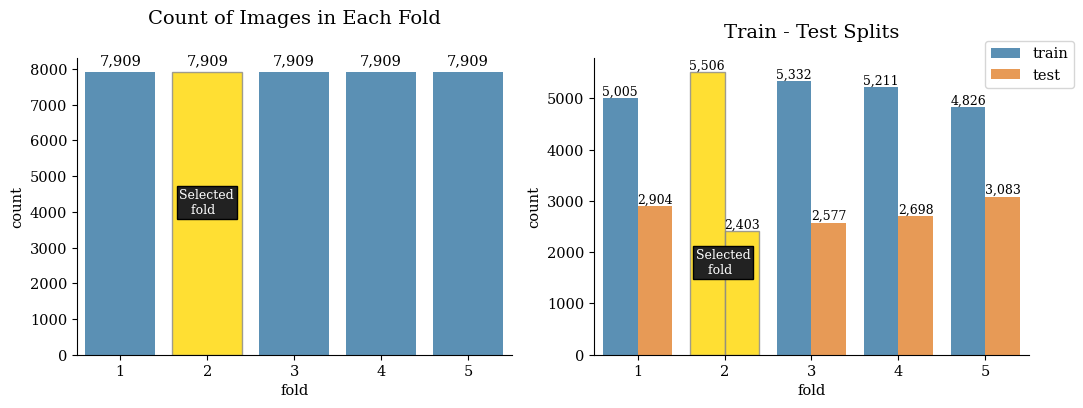

In [ ]:
# Select the fold with the highest proportion of training images
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold").copy().reset_index(drop=True)

# Update the filename to the correct path in the Colab environment
selected_fold_data["filename"] = ("/content/BreaKHis_v1/" + selected_fold_data["filename"])

# Create plots for visualization
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.2), tight_layout=True)

# Plot image count in each fold
sb.countplot(data=fold_info, x="fold", color="C0", ax=ax1, alpha=0.8)
bars = ax1.containers[0]
ax1.bar_label(bars, padding=3, labels=[f"{x:,.0f}" for x in bars.datavalues])
_selected_bar = bars[selected_fold - 1]
_selected_bar.set_facecolor("gold")
_selected_bar.set_edgecolor("#888")
ax1.text(_selected_bar.get_x() + 0.08, _selected_bar.get_height() / 2,
          "Selected\n   fold", size=9, color="#fff",
          bbox={"pad": 2, "facecolor": "#222"})
ax1.set_title("Count of Images in Each Fold", size=14, pad=25)

# Plot train-test split
sb.countplot(data=fold_info, x="fold", hue="grp", palette="tab10", ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    bars[selected_fold - 1].set_facecolor("gold")
    bars[selected_fold - 1].set_edgecolor("#888")
ax2.text(_selected_bar.get_x() + 0.07, _selected_bar.get_height() / 5,
          "Selected\n   fold", size=9, color="#fff",
          bbox={"pad": 2, "facecolor": "#222"})
ax2.set_title("Train - Test Splits", size=14, pad=15)
ax2.legend(loc=(0.9, 0.9))

plt.show()


# Magnification factors
In previous research by Ashtaiwi (2022), titled Optimal Histopathological Magnification Factors for Deep Learning-Based Breast Cancer Prediction, it was found that training models using images with a magnification factor of at least 200X leads to the best performance in predicting breast cancer. This conclusion highlights the importance of selecting the appropriate magnification for accurate analysis.

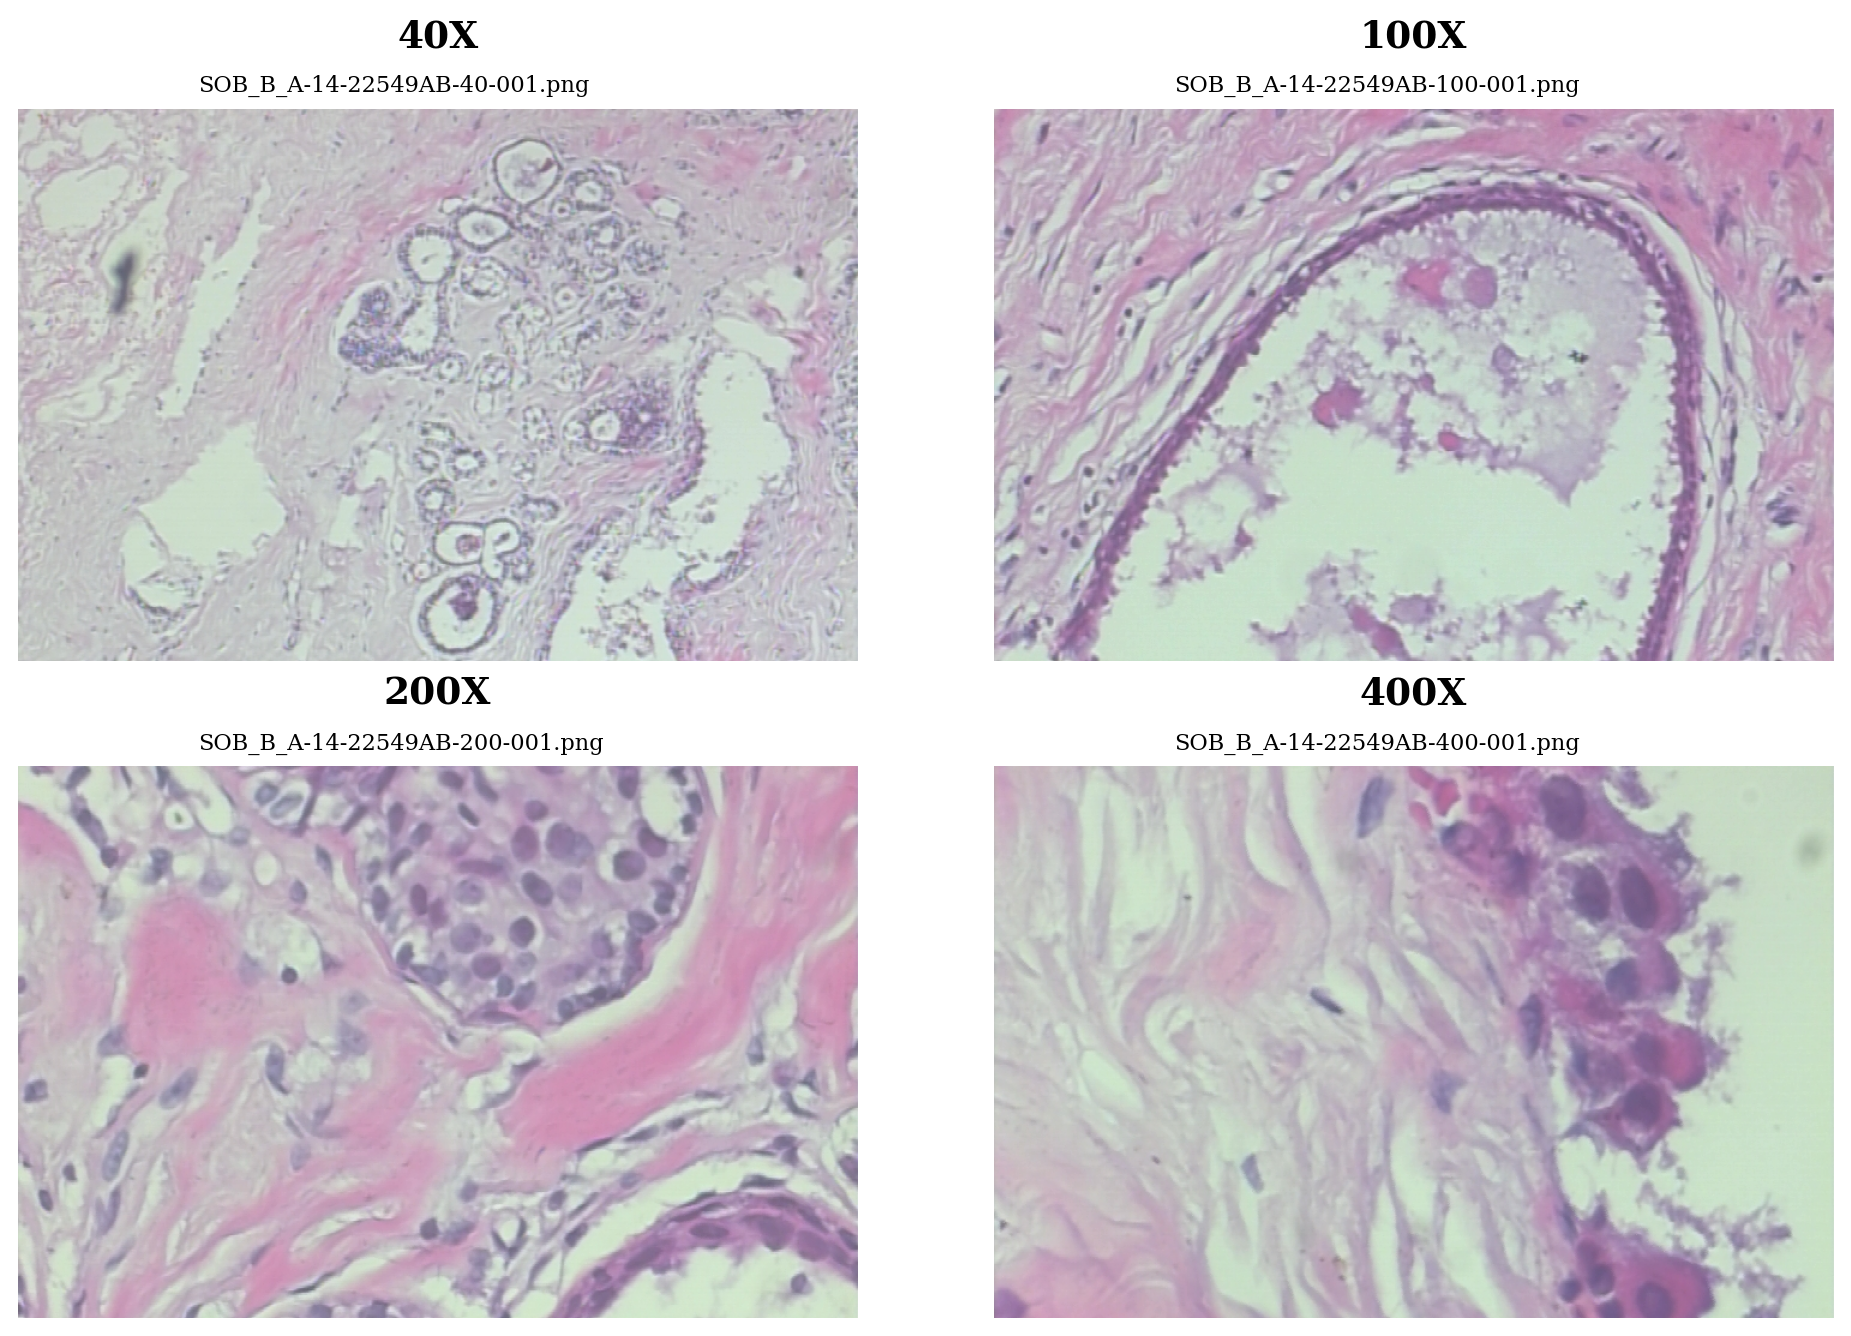

In [ ]:
# Magnification factors visualization
# The study indicates that training models on images with a magnification factor of at least 200X yields the best results.
# We will visualize sample images from the selected fold at different magnification factors.

fig, axes = plt.subplots(2, 2, figsize=(11, 7.5), dpi=180, tight_layout=True)

# Group the selected fold data by magnification
sample_images = selected_fold_data.groupby("mag", as_index=False).first()

# Loop through the axes and the sample images to display them
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)  # Open the image file
    ax.imshow(img)  # Display the image
    ax.set_title(f"{row.mag}X", size=15, pad=25, weight=600)  # Set the title with magnification
    ax.text(150, -15, row.filename.split("/")[-1], size=9)  # Display the filename
    ax.axis("off")  # Turn off axis

plt.show()  # Show the plot


# Image Validation
There are about 256 (3.16%) duplicate images. On inspection, duplicated pairs have similar slide-ID but different tumour types; which might suggest that those slides capture more than 1 tumour type (and perhaps also human error).

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7909 [00:00<?, ?it/s]

  0%|          | 0/7909 [00:00<?, ?it/s]

Issue checks completed. 330 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          250 |
|  1 | odd_size         |           74 |
|  2 | near_duplicates  |            6 |
|  3 | dark             |            0 |
|  4 | light            |            0 |
|  5 | blurry           |            0 |
|  6 | low_information  |            0 |
|  7 | odd_aspect_ratio |            0 |
|  8 | grayscale        |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 250
Examples representing most severe instances of this issue:

Set: 0


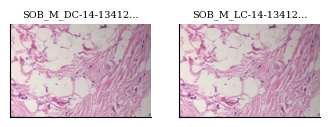

Set: 1


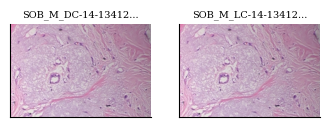

Set: 2


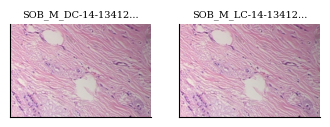

Set: 3


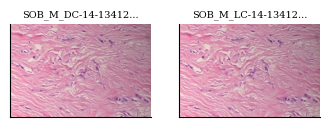

--------------------- odd_size images ----------------------

Number of examples with this issue: 74
Examples representing most severe instances of this issue:



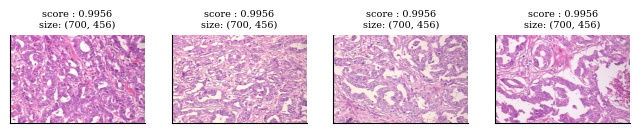

------------------ near_duplicates images ------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:

Set: 0


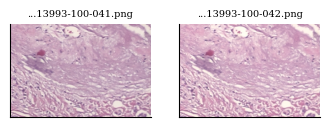

Set: 1


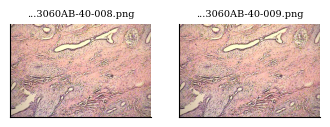

Set: 2


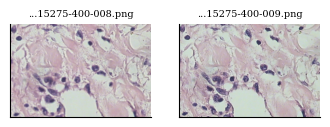

In [ ]:
# Import the necessary library for image validation
from cleanvision import Imagelab

# Initialize Imagelab with the file paths of the selected fold
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))

# Find issues in the dataset, including duplicates
imagelab.find_issues()

# Generate a report of the findings with high verbosity
imagelab.report(verbosity=4)


In [ ]:
# Identify duplicated images based on issues found in Imagelab
duplicated_images = imagelab.issues[
    ["is_exact_duplicates_issue", "is_near_duplicates_issue"]
].any(axis=1).reset_index().rename(columns={"index": "filename", 0: "duplicated"})

# Display the first few rows of the duplicated images DataFrame
duplicated_images.head()


filename  duplicated
0  /content/BreaKHis_v1/BreaKHis_v1/histology_sli...       False
1  /content/BreaKHis_v1/BreaKHis_v1/histology_sli...       False
2  /content/BreaKHis_v1/BreaKHis_v1/histology_sli...       False
3  /content/BreaKHis_v1/BreaKHis_v1/histology_sli...       False
4  /content/BreaKHis_v1/BreaKHis_v1/histology_sli...       False

In [ ]:
# Check that filenames align
assert duplicated_images["filename"].equals(selected_fold_data["filename"]), "Filenames do not align!"

# Drop all duplicated images from the selected fold data
selected_fold_data = selected_fold_data[~duplicated_images["duplicated"]]

# Reinitialize Imagelab with the updated file paths of the selected fold (after removing duplicates)
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))

# Find issues in the updated dataset again
imagelab.find_issues()


In [ ]:
# Use data in the selected folder with magnification factor >= 200X
train = selected_fold_data.query("mag >= 200 and grp == 'train'")
test = selected_fold_data.query("mag >= 200 and grp == 'test'")

# Display the shapes of the training and testing datasets
train_shape, test_shape = train.shape, test.shape
train_shape, test_shape


# Target Distribution
There are significantly more images of malignant cases than there are of benign ones:

In [ ]:
# Target Distribution Visualization
# There are significantly more images of malignant cases than there are of benign ones

# Define class mapping and names
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())

# Count the occurrences of each class in the training data
label_counts = train["label"].value_counts(ascending=True)

# Plot the distribution using a bar chart
ax = label_counts.plot.bar(color=["skyblue", "hotpink"], alpha=0.8, figsize=(5, 3.5))

# Add bar labels showing counts and proportions
ax.bar_label(ax.containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])

# Set x-tick labels
ax.set_xticklabels(class_names, rotation=0)

# Set plot title and labels
ax.set_title("Target Distribution in Training Data", size=14)
ax.set_ylabel("Number of Images", size=12)
ax.set_xlabel("Classes", size=12)

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot


When there's a classification problem with a large imbalance between classes, relying on accuracy alone isn't a good way to judge how well a model is performing. Why? Because the model could simply predict the majority class most of the time and still get a high accuracy, even if it's not identifying the minority class correctly.

For example, if a classifier predicts that all cases are "malignant," it might get an accuracy of 65.94%, but it wouldn't identify any "benign" cases. In this case, if we use another metric like ROC-AUC, the model would only score 50%, which shows that the model is no better than random guessing.

In [ ]:
# Convert labels to numerical format using the classes mapping
y = train["label"].map(classes)

# Create predictions that only predict the majority class (malignant)
positive_only_preds = np.ones_like(y)

# Calculate and print accuracy and ROC-AUC scores
accuracy = metrics.accuracy_score(y, positive_only_preds)
roc_auc = metrics.roc_auc_score(y, positive_only_preds)

print(f"Accuracy: {accuracy:.2%}",
      f"\nROC-AUC:  {roc_auc:.2%}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
from matplotlib import ticker

# Draw a confusion matrix with descriptions
fig, ax = plt.subplots(figsize=(5.4, 3.6))
# Define color zones for the confusion matrix
ax.axvspan(0, 0.5, 0.5, 1, facecolor="skyblue", alpha=0.8, edgecolor="black")
ax.axvspan(0.5, 1, 0.5, 1, facecolor="#fe7", edgecolor="black")
ax.axvspan(0, 0.5, 0, 0.5, facecolor="#fe7", edgecolor="black")
ax.axvspan(0.5, 1, 0, 0.5, facecolor="hotpink", alpha=0.8, edgecolor="black")

# Add text annotations for each section of the confusion matrix
ax.text(0.1, 0.85, "True Negative", size=12, weight=600)
ax.text(0.05, 0.7, "Model predicts benign.\nCase is benign.", size=9)
ax.text(0.6, 0.85, "False Positive", size=12, weight=600)
ax.text(0.55, 0.7, "Model predicts malignant.\nCase is actually benign.", size=9)
ax.text(0.1, 0.35, "False Negative", size=12, weight=600)
ax.text(0.05, 0.2, "Model predicts benign.\nCase is actually malignant.", size=9)
ax.text(0.6, 0.35, "True Positive", size=12, weight=600)
ax.text(0.55, 0.2, "Model predicts malignant\nCase is malignant.", size=9)

# Configure axes
ax.set_xlim(0, 1.005)
ax.xaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.xaxis.set_ticklabels([0, 1])
ax.yaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.yaxis.set_ticklabels([1, 0])
ax.set_ylabel("Actual Condition", size=12, labelpad=10)
ax.set_xlabel("Model Prediction", size=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
ax.spines["left"].set_position("zero")
ax.tick_params(pad=0, top=False, left=False)
fig.suptitle("Confusion Matrix Reference", y=1.1, size=16)

# Plot metrics for positive-only predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, positive_only_preds, ax=ax1, name="positive_only_predictor")
metrics.ConfusionMatrixDisplay.from_predictions(y, positive_only_preds, ax=ax2, colorbar=False)
ax1.text(0.65, 0.15, f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2f}")
fig.suptitle("ROC-AUC and Confusion Matrix for a Positive-Only Predictor", size=13)

# Plot metrics for "perfect" predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, y, ax=ax1, name="perfect_predictor")
ax1.text(0.65, 0.15, f"Accuracy: {metrics.accuracy_score(y, y):.2f}")
metrics.ConfusionMatrixDisplay.from_predictions(y, y, ax=ax2, colorbar=False)
fig.suptitle("ROC-AUC and Confusion Matrix for a Perfect Predictor", size=13)

plt.show()  # Display all plots


# Data Ingestion & Preprocessing
Images need to be converted into numeric form for consumption by computer vision models.

We'll use the tensorflow image module to:

load the PNG image files
decode the images and convert them to 3D tensors
resize the images to a uniform size (some have 760x460 pixels while some have 760x456).

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from typing import Tuple

# Set constants
IMG_SIZE = 224
BATCH_SIZE = 28
SEED = 42  # Set your desired random seed

# Function to load and preprocess images
def load_image(filename: str, label: int) -> Tuple[tf.Tensor, int]:
    file = tf.io.read_file(filename)  # Read the image file
    img = tf.image.decode_png(file, channels=3)  # Decode PNG image
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)  # Resize image to uniform size
    return img, label  # Return the image tensor and label

# Prepare training and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(
    train["filename"],
    train["label"].map(classes),
    random_state=SEED
)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
             .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
             .batch(BATCH_SIZE)

validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))\
                  .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
                  .batch(BATCH_SIZE)

# Prepare test dataset
test = test.sample(frac=1, random_state=SEED)  # Shuffle test data
test_ds = tf.data.Dataset.from_tensor_slices(
    (test["filename"], test["label"].map(classes))
).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
 .batch(BATCH_SIZE)

# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Example to check the shape of the datasets
for images, labels in train_ds.take(1):
    print(images.shape, labels.numpy())


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure for displaying images
plt.figure(figsize=(14, 6))

# Iterate over the training dataset to fetch images and labels
for images, labels in train_ds.take(1):
    labels = labels.numpy()  # Convert labels to NumPy array
    for i in range(10):  # Display 10 images
        ax = plt.subplot(2, 5, i + 1)  # Create a subplot for each image
        plt.imshow(images[i].numpy().astype(np.uint8))  # Display the image
        label = class_names[labels[i]]  # Get the class name for the label
        title_color = "blue" if label == "benign" else "deeppink"  # Set title color based on label
        plt.title(label, color=title_color)  # Set title for the image
        plt.axis("off")  # Hide the axis
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the figure with images


# Data Augmentation:

Data augmentation is a technique we use to increase the size of the dataset we train the model on. The idea is simple: we take the same images we have and apply small changes to them, like making them darker, flipping them horizontally or vertically, or rotating them. This not only increases the amount of data but also helps the model learn to be flexible with different variations of the images.

For example, if the model sees a rotated or flipped image, it will learn that the orientation isn't important when identifying cancerous cells.

Some of the methods used here include:

Random brightness shifts to help deal with different lighting conditions.
Random horizontal and vertical flips to handle different orientations.
Random rotations to also address different image orientations.

In [ ]:

import tensorflow as tf
import matplotlib.pyplot as plt

# Load a sample image from the training data
sample_image = load_image(*train[["filename", "label"]].iloc[0])[0]

# Define a function to plot augmentations
def plot_augmentations(augmentation_layer: tf.keras.layers.Layer) -> None:
    augment_name = augmentation_layer.name  # Get the name of the augmentation layer
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(15, 4))  # Set up the figure for subplots
    ax0.imshow(sample_image.numpy().astype("uint8"))  # Display the original image
    ax0.set_title("Original", size=14, pad=10)  # Title for the original image
    ax0.axis("off")  # Hide the axis
    for idx, ax in enumerate(axes):
        augmented_image = augmentation_layer(sample_image)  # Apply the augmentation
        ax.imshow(augmented_image.numpy().astype("uint8"))  # Display the augmented image
        ax.set_title(augment_name.title(), size=14, pad=10)  # Title for the augmented image
        ax.axis("off")  # Hide the axis
    plt.show()  # Show the figure with images



In [ ]:
# Plotting augmentations for Random Brightness
plot_augmentations(tf.keras.layers.RandomBrightness(0.2))


In [ ]:
# Plotting augmentations for Random Flip
plot_augmentations(tf.keras.layers.RandomFlip())


In [ ]:
# Plotting augmentations for Random Rotation
plot_augmentations(tf.keras.layers.RandomRotation(0.2, seed=SEED))


## Helper functions

In [ ]:
# Constants
MAX_EPOCHS = 25
BASE_LEARNING_RATE = 0.001

def compile_and_fit_model(
    model: tf.keras.Model,
    learning_rate: float=BASE_LEARNING_RATE,
    epochs: int=MAX_EPOCHS
) -> tf.keras.callbacks.History:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc"), "binary_accuracy"]
    )

    # Remove EarlyStopping
    early_stopping = EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)

    # Train without EarlyStopping
    history = model.fit(train_ds, validation_data=validation_ds,
                        epochs=epochs, callbacks=[reduce_lr])  # No EarlyStopping

    # Plot training metrics
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
    for ax, metric in zip(axes.flat, ["Accuracy", "Loss"]):
        performance_df.filter(like=metric.lower()).plot(ax=ax)
        ax.set_title(metric, size=14, pad=10)
        ax.set_xlabel("epoch")
    return history

# Evaluate the model function remains unchanged
def evaluate_model(model: tf.keras.Model, dataset: tf.data.Dataset=test_ds) -> None:
    loss, auc, accuracy = model.evaluate(dataset, verbose=0)
    print(f"\nROC-AUC:   {auc:.5f}",
          f"Accuracy:  {accuracy:.5f}",
          f"Loss:      {loss:.5f}\n", sep="\n")
    # Get labels and predictions for each batch in dataset
    results = [(labels, model.predict(images, verbose=0).reshape(-1))
               for images, labels in dataset.take(-1)]
    labels = np.concatenate([x[0] for x in results])
    preds = np.concatenate([x[1] for x in results])
    # Plot metrics
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
    curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
    for ax, curve in zip(axes[:2], curves):
        curve.from_predictions(labels, preds, ax=ax, name=model.name)
    metrics.ConfusionMatrixDisplay.from_predictions(
        labels, preds.round().astype("uint8"), ax=axes[2], colorbar=False,
    )
    titles = ["ROC-AUC Curve", "Precision-Recall Curve", "Confusion Matrix"]
    for ax, title in zip(axes.flat, titles):
        ax.set_title(title, size=14, pad=10)

def plot_predictions(model: tf.keras.Model) -> None:
    plt.figure(figsize=(14, 9))
    for images, labels in test_ds.take(1):
        labels = labels.numpy()
        predicted_labels = model.predict(images).round().astype("uint8").reshape(-1,)
        print("Predicted:", predicted_labels)
        print("Actual:   ", labels)
        for i, (pred, actual) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(4, 7, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if pred == actual:
                plt.title(class_names[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_names[predicted_labels[i]]}\n"
                          + f"(Actual: {class_names[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")


# Custom Convolutional Neural Network
A Convolutional Neural Network (CNN) is a class of artificial neural networks that is well suited for computer vision problems. It excels at finding patterns (features) in images (see introduction to CNNs).

In [ ]:
# Define the custom CNN model
custom_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # Convolutional block I
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Convolutional block II
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Convolutional block III
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Fully connected layers
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")  # Output layer for binary classification
], name="CustomCNN")

# Display the model summary
custom_model.summary()

In [ ]:
# Compile and fit the custom model
custom_history = compile_and_fit_model(custom_model)


In [ ]:
# Evaluate the custom model
evaluate_model(custom_model)


In [ ]:
# Plot predictions of the custom model
plot_predictions(custom_model)


# Transfer Learning:

Transfer learning is the practice of applying knowledge gained from one task to a related task. This approach is widely used in computer vision problems to achieve high performance with minimal data by leveraging pre-trained models that have learned how to extract features from large collections of images, such as the ImageNet database.

Let's take a look at how some of the most popular model architectures perform on this dataset.


In [ ]:
IMG_SIZE = 224  # Assuming this is the image size used earlier
SEED = 42  # Replace with your seed value if different

# Load pre-trained MobileNetV3 model
pretrained_mobnet_base = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_mobnet_base.trainable = False  # Freeze the base model

# Build the MobileNetV3 model
mobnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # MobileNet
    layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
    pretrained_mobnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="MobileNetV3")

# Show model summary
mobnet_model.summary()

In [ ]:
mobnet_history = compile_and_fit_model(mobnet_model)

In [ ]:
evaluate_model(mobnet_model)

In [ ]:
plot_predictions(mobnet_model)

# Model with EfficientNetB1 base

> Add blockquote


EfficientNet paper: https://arxiv.org/abs/1905.11946

In [ ]:
# Model with EfficientNetB1 base
pretrained_efficientnet_base = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # EfficientNet
    pretrained_efficientnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="EfficientNetB1")

# Display model summary
efficientnet_model.summary()


In [ ]:
efficientnet_history = compile_and_fit_model(efficientnet_model)


In [ ]:
evaluate_model(efficientnet_model)


This model is very promising. It has attained the highest test ROC-AUC score so far. But the number of false positives (120) is a concern. There is room for improvement.

In [ ]:
# Plot predictions to see how well the model performs
plot_predictions(efficientnet_model)

**bold text**## Model with VGG16 base
VGG paper: https://arxiv.org/abs/1409.1556


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Assuming IMG_SIZE and SEED are already defined
IMG_SIZE = 224  # Example value, replace as necessary
SEED = 42  # Example value, replace as necessary

# Load pre-trained VGG16 model
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_vgg16_base.trainable = False  # Freeze the base model

# Build the VGG16 model
vgg16_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # VGG16
    layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dropout(0.4),  # Dropout for regularization
    # Fully connected layers
    layers.Dense(384, activation="relu"),
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),  # Dropout for regularization
    layers.Dense(1, activation="sigmoid")  # Output layer for binary classification
], name="VGG16")

# Display model summary
vgg16_model.summary()


In [ ]:
# Compile and fit the model using your previously defined function
vgg16_history = compile_and_fit_model(vgg16_model)

In [ ]:

# Evaluate the VGG16 model
evaluate_model(vgg16_model)


In [ ]:

# Plot predictions to see how well the model performs
plot_predictions(vgg16_model)

bold text## Model with ResNet50V2 base
ResNetV2 paper: https://arxiv.org/abs/1603.05027

In [ ]:
pretrained_resnet_base = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_resnet_base.trainable = False  # Freeze the base model

# Build the ResNet model
resnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # ResNet
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input),
    pretrained_resnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")  # Output layer for binary classification
], name="ResNet50V2")

# Display model summary
resnet_model.summary()


In [ ]:
# Compile and fit the model (using your previously defined function)
resnet_history = compile_and_fit_model(resnet_model)


In [ ]:
# Evaluate the model
evaluate_model(resnet_model)

In [ ]:
# Plot predictions to see how well the model performs
plot_predictions(resnet_model)

# Model Evaluation

The EfficientNetB1 model achieved the least loss (0.386096) and highest ROC-AUC score (0.876673) on the test dataset.

The custom CNN model attained the highest accuracy score (0.854656).

In [ ]:

# List of fitted models
fitted_models = [custom_model, mobnet_model, efficientnet_model, vgg16_model, resnet_model]

# Evaluate models and create a DataFrame for metrics
test_metrics = pd.DataFrame(
    {model.name: model.evaluate(test_ds, verbose=0) for model in fitted_models},
    index=["Loss", "ROC-AUC", "Accuracy"]
)

# Highlighting minimum and maximum values
test_metrics.style.highlight_min(color="gold", axis=None)\
                  .highlight_max(color="lawngreen", axis=None)


In [ ]:

# Process training metrics
hist_list = [custom_history, mobnet_history, efficientnet_history, vgg16_history, resnet_history]
train_metrics = pd.concat([pd.DataFrame(hist.history) for hist in hist_list],
                          axis=1, keys=[hist.model.name for hist in hist_list])
train_metrics.head()

# Define color mapping for plots
color_dict = dict(zip(test_metrics.columns, plt.colormaps["Set2"].colors))

# Plot training and test metrics
fig, axes = plt.subplot_mosaic("\naab\nccd\neef\n", figsize=(11, 11), dpi=180, tight_layout=True)

# Plot training metrics
for ax, metric in zip([axes["a"], axes["c"], axes["e"]],
                      ["val_roc_auc", "val_binary_accuracy", "val_loss"]):
    data_ = train_metrics.filter(like=metric)
    data_.plot(ax=ax, lw=3, color=[color_dict[col] for col in data_.columns.levels[0]])
    ax.set_xlabel("Epochs", size=11)

# Plot test metrics
for ax, metric in zip([axes["b"], axes["d"], axes["f"]],
                      ["ROC-AUC", "Accuracy", "Loss"]):
    data_ = test_metrics.loc[metric].sort_values()
    data_.plot.barh(ax=ax, color=[color_dict[col] for col in data_.index])
    ax.bar_label(ax.containers[0], [f"{x:.5f}" for x in ax.containers[0].datavalues])
    ax.bar_label(ax.containers[0], data_.index, label_type="center")
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.spines["bottom"].set_visible(False)

# Set titles for the plots
titles = ["Training ROC-AUC", "Test ROC-AUC", "Training Accuracy", "Test Accuracy",
          "Training Loss", "Test Loss"]
for ax, title in zip(axes.values(), titles):
    ax.set_title(title, size=16, loc="left")

# Legend adjustments
axes["a"].legend(title="")
axes["c"].legend(title="")
axes["e"].legend(title="")

plt.show()



# Ensemble

> _"The whole is greater than the sum of its parts."_ - Aristotle

Machine learning models can be combined into a composite model that is often better than any individual model. This is referred to as [Ensembling][ensemble].

Common ensembling techniques include:

1. **Bagging:** Fitting several "whole/full" models on subsets of the data (and even subsets of the features), then aggregating their results e.g. A Random-forest consists of several decision tree models.
2. **Boosting:** Starts with a "weak/shallow" model, then successively adds weak models focused on portions of the data that the overall model is performing poorly on e.g. a Gradient-boosting model consists of several shallow decision tree models.
3. **Stacking:** Using predictions from several models as inputs to a final estimator.

Let's investigate if [stacking][stacking] can improve the results:

(Thanks [@Tilii for suggesting this][comment])

[ensemble]: https://en.wikipedia.org/wiki/Ensemble_learning
[stacking]: https://en.wikipedia.org/wiki/Ensemble_learning#Stacking
[comment]: https://www.kaggle.com/code/timothyabwao/detecting-breast-cancer-with-computer-vision/comments#2188846



In [ ]:
import numpy as np
import tensorflow as tf
from typing import Tuple

def get_predictions_and_labels(dataset: tf.data.Dataset, fitted_models: list) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get labels and predictions for each batch in the dataset.

    Args:
        dataset: A tf.data.Dataset object to extract images and labels from.
        fitted_models: List of fitted models to make predictions.

    Returns:
        Tuple of predictions and actual labels.
    """
    results = [
        (labels, [model.predict(images, verbose=0).reshape(-1,) for model in fitted_models])
        for images, labels in dataset.take(-1)
    ]

    # Concatenate labels and predictions
    labels = np.concatenate([x[0] for x in results])
    preds = np.concatenate([x[1] for x in results], axis=1).transpose()

    return preds, labels

# Get predictions and labels for training, validation, and test datasets
train_preds, train_labels = get_predictions_and_labels(train_ds, fitted_models)
valid_preds, valid_labels = get_predictions_and_labels(validation_ds, fitted_models)
test_preds, test_labels = get_predictions_and_labels(test_ds, fitted_models)

# Optionally: Print the shapes of the predictions and labels for verification
print(f"Training predictions shape: {train_preds.shape}, Training labels shape: {train_labels.shape}")
print(f"Validation predictions shape: {valid_preds.shape}, Validation labels shape: {valid_labels.shape}")
print(f"Test predictions shape: {test_preds.shape}, Test labels shape: {test_labels.shape}")


In [ ]:
# Stacking ensemble with Logistic Regression
stacking_model = LogisticRegressionCV(scoring="roc_auc")
stacking_model.fit(train_preds, train_labels)

# Predict probabilities on the test dataset
stacked_preds = stacking_model.predict_proba(test_preds)

# Update test metrics DataFrame with stacking ensemble results
test_metrics["Stacking Ensemble"] = [
    metrics.log_loss(test_labels, stacked_preds),
    metrics.roc_auc_score(test_labels, stacked_preds[:, 1]),  # get stacked +ve probability
    metrics.accuracy_score(test_labels, stacked_preds.argmax(axis=1))  # get stacked predicted label
]

# Display test metrics with highlighting
test_metrics.style.highlight_min(color="gold", axis=None)\
                  .highlight_max(color="lawngreen", axis=None)




The stacked ensemble significantly improves the test ROC-AUC score, but the EfficientNetB1 model still yields the least loss.



In [ ]:
# Save models for deployment in the keras format
custom_model.save("custom_cnn.keras")
mobnet_model.save("mobnetv3sm.keras")
efficientnet_model.save("efficientnetv2B1.keras")
vgg16_model.save("vgg16.keras")
resnet_model.save("resnet50v2.keras")

# Display file sizes of the saved models
!du -h *.keras  # view file size


In [ ]:
from google.colab import files

# List of model filenames to download
model_filenames = [
    "custom_cnn.keras",
    "mobnetv3sm.keras",
    "efficientnetv2B1.keras",
    "vgg16.keras",
    "resnet50v2.keras"
]

# Download each model file
for filename in model_filenames:
    files.download(filename)
